In [1]:
import sys
sys.path.append('../')

In [34]:
import torchxrayvision as xrv
import torchvision
import torch

import numpy as np
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm, trange
import seaborn as sns
%matplotlib inline

In [13]:
# from src.chexnet import DenseNet121
# from src.xrayvision import COVID19_Dataset
from torchxrayvision.datasets import COVID19_Dataset

In [15]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

d_covid19 = COVID19_Dataset(
    '/Users/aniket/Google Drive/Projects/covid-research/data/covid-chestxray-dataset/images',
    '/Users/aniket/Google Drive/Projects/covid-research/data/covid-chestxray-dataset/metadata.csv',
    transform=transform)

In [16]:
model = xrv.models.DenseNet(weights='all') # CheXpert (Stanford)
model = model.eval()

# KNN for only Covid-19

In [31]:
d_covid19

{'Aspergillosis': {0.0: 534, 1.0: 1},
 'Aspiration': {0.0: 534, 1.0: 1},
 'Bacterial': {0.0: 487, 1.0: 48},
 'COVID-19': {0.0: 193, 1.0: 342},
 'Chlamydophila': {0.0: 534, 1.0: 1},
 'Fungal': {0.0: 512, 1.0: 23},
 'H1N1': {0.0: 534, 1.0: 1},
 'Herpes ': {0.0: 532, 1.0: 3},
 'Influenza': {0.0: 531, 1.0: 4},
 'Klebsiella': {0.0: 526, 1.0: 9},
 'Legionella': {0.0: 526, 1.0: 9},
 'Lipoid': {0.0: 527, 1.0: 8},
 'MERS-CoV': {0.0: 527, 1.0: 8},
 'MRSA': {0.0: 534, 1.0: 1},
 'Mycoplasma': {0.0: 530, 1.0: 5},
 'No Finding': {0.0: 520, 1.0: 15},
 'Nocardia': {0.0: 531, 1.0: 4},
 'Pneumocystis': {0.0: 513, 1.0: 22},
 'Pneumonia': {0.0: 26, 1.0: 509},
 'SARS': {0.0: 519, 1.0: 16},
 'Staphylococcus': {0.0: 534, 1.0: 1},
 'Streptococcus': {0.0: 518, 1.0: 17},
 'Tuberculosis': {0.0: 524, 1.0: 11},
 'Varicella': {0.0: 530, 1.0: 5},
 'Viral': {0.0: 157, 1.0: 378}}


COVID19_Dataset num_samples=535 views=['PA', 'AP']

In [32]:
xrv.datasets.relabel_dataset(['COVID-19'], d_covid19)

{'MERS-CoV', 'Influenza', 'Varicella', 'Nocardia', 'Streptococcus', 'Pneumocystis', 'Legionella', 'Lipoid', 'Mycoplasma', 'Chlamydophila', 'No Finding', 'Bacterial', 'Viral', 'Pneumonia', 'Tuberculosis', 'Aspergillosis', 'Herpes ', 'Staphylococcus', 'Klebsiella', 'Fungal', 'H1N1', 'SARS', 'MRSA', 'Aspiration'} will be dropped


In [35]:
features = []
labels = []
for idx in trange(0, len(d_covid19)):
    image = d_covid19[idx]['img']
    image = torch.from_numpy(image).expand(1, 1, 224, 224)
    label = d_covid19[idx]['lab']

    feature = model.features(image)
    features.append(feature)
    labels.append(label)

AvgPool2d(kernel_size=(7, 7), stride=(7, 7), padding=0)

In [49]:
X = []
avg_pool = torch.nn.AvgPool2d((7,7))
for e in features:
    X.append(avg_pool(e).detach().numpy().reshape(1024))
X = np.asarray(X)

In [59]:
labels = np.asarray(labels)

## Split train test

In [103]:
split_pct = 0.7
indexes = list(range(len(X)))
random.shuffle(indexes)

train_idx = indexes[:int(split_pct*len(indexes))]
test_idx = indexes[int(split_pct*len(indexes)):]

data = {}
data['train'] = X[train_idx], labels[train_idx]
data['test'] = X[test_idx], labels[test_idx]

print(len(train_idx), len(test_idx))

374 161


In [104]:
np.sum(labels[train_idx]==1), np.sum(labels[train_idx]==0)

(241, 133)

In [105]:
np.sum(labels[test_idx]==1), np.sum(labels[test_idx]==0)

(101, 60)

In [106]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, confusion_matrix

from sklearn.metrics import plot_confusion_matrix, auc, roc_auc_score


In [107]:
knn = KNeighborsClassifier(n_neighbors=8, p=2)

In [108]:
knn.fit(*data['train'])

KNeighborsClassifier(n_neighbors=8)

In [109]:
knn.score(*data['train'])

0.7887700534759359

In [110]:
knn.score(*data['test'])

0.7018633540372671

In [111]:
y_pred = knn.predict(data['test'][0])
y_true = data['test'][1]

In [112]:
precision_score(y_true, y_pred), recall_score(y_true, y_pred)

(0.7304347826086957, 0.8316831683168316)

In [113]:
f1_score(y_true, y_pred)

0.7777777777777777

In [114]:
# knn.predict_proba(X_[test_idx])

In [115]:
precision, recall, thresh = precision_recall_curve(
                                y_true,
                                knn.predict_proba(data['test'][0])[..., 1]
                            )

In [116]:
precision

array([0.62732919, 0.64102564, 0.64900662, 0.66911765, 0.73043478,
       0.82666667, 0.85714286, 0.83333333, 1.        ])

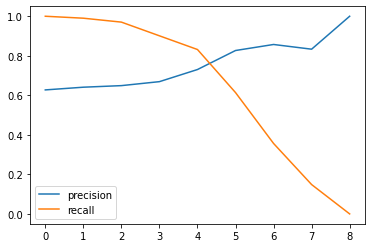

In [117]:
plt.plot(precision)
plt.plot(recall)

plt.legend(('precision', 'recall'))
plt.show()

In [118]:
cm = confusion_matrix(
        y_true=y_true,
        y_pred=y_pred
    )

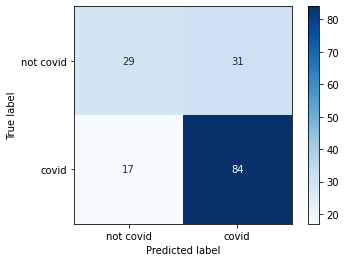

In [128]:
disp = plot_confusion_matrix(knn, data['test'][0], data['test'][1], 
                          labels=(0, 1),
                          display_labels=('not covid', 'covid'),
                          cmap=plt.cm.Blues
                         )

# disp.ax_.set_title('Confusion Matrix of KNN score')
plt.savefig('../images/knn-confusion-matrix.svg')
plt.show()

In [127]:
roc_auc_score(y_true, knn.predict_proba(data['test'][0])[..., 1])

0.732013201320132